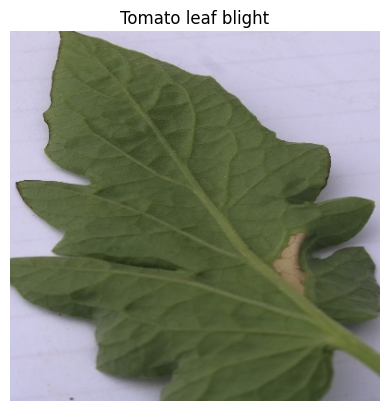

(400, 400, 3)
/home/wouter/code/MahautHDL/save_the_crops/raw_data/
['Cassava brown spot', 'Cassava mosaic', 'Cassava green mite', 'Tomato leaf blight', 'Cashew leaf miner', 'Cassava healthy', 'Cassava bacterial blight', 'Cashew gumosis', 'Maize leaf blight', 'Maize fall armyworm', 'Tomato leaf curl', 'Tomato verticulium wilt', 'Maize grasshoper', 'Maize streak virus', 'Cashew red rust', 'Tomato healthy', 'Cashew healthy', 'Maize leaf beetle', 'Cashew anthracnose', 'Tomato septoria leaf spot', 'Maize leaf spot', 'Maize healthy']


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ! unzip -n ~/code/MahautHDL/save_the_crops/raw_data/crop.zip -d ~/code/MahautHDL/save_the_crops/raw_data

data_link = os.environ.get("LOCAL_PATH")

crops = os.listdir(data_link)
plant_disease = np.random.randint(0, len(crops))
plant_disease_name = crops[plant_disease]

os.chdir(f'{data_link}{plant_disease_name}')

link = os.listdir(f"{data_link}{plant_disease_name}")
rand_pic_nr = np.random.randint(0, len(link))

img = plt.imread(link[rand_pic_nr])

plt.imshow(img)
plt.axis(False)
plt.title(plant_disease_name)
plt.show()
print(img.shape)
print(data_link)
print(crops)

In [31]:
# Putting non-corrupted pictures into a datafile

import tensorflow as tf
import pandas as pd
import os

data_link = os.environ.get("LOCAL_PATH")

def import_and_preprocess_pictures(directory=data_link):
    # delete_list = pd.DataFrame(columns=["class", "filename"])
    data = pd.DataFrame(columns=["filename", "class"])

    crops = os.listdir(data_link)

    for i in range(0,len(crops)):
        plant_disease_name = crops[i]
        os.chdir(f'{data_link}{plant_disease_name}')

        filenames = os.listdir(f"{data_link}{plant_disease_name}")

        for index, filename in enumerate(filenames):
            if filename.endswith(".jpg"):

                try:
                    tensor_img = plt.imread(filename)
                    data.loc[len(data)] = [f'{plant_disease_name}/{filename}', plant_disease_name]


                except:
                    # delete_list.loc[len(delete_list)] = [plant_disease_name, filename]
                    # delete_list.append(f'{plant_disease_name} - {filename}')
                    pass
            else:
                pass
        # break

    return data

data = import_and_preprocess_pictures()
data.to_csv(f'{os.environ.get("DATA_PATH")}data.csv', index=False)

In [32]:
# Upload csv of uncorrupted files into dataframe

data = pd.read_csv(f"{os.environ.get('DATA_PATH')}data.csv")
data

50